## Problem 1: A detailed View to MNIST Classification

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torch import nn, optim
import torch.nn.functional as F

In [15]:
# defining transformations
transformations = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,)),])

# downloading and loading train data
mnist_train = torchvision.datasets.MNIST('mnist_train', train=True, download=True, transform=transformations)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=256, shuffle=True)

# downloading and loading test data
mnist_test = torchvision.datasets.MNIST('mnist_test', train=False, download=True, transform=transformations)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=True)

In [16]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        #self.bn = nn.BatchNorm1d(784)
        self.input = nn.Linear(784, 1024)
        self.fc1 = nn.Linear(1024, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.out = nn.Linear(1024, 10)
    
    def forward(self, img):
        # flatten the image
        x = img.view(img.shape[0], -1)
        
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.out(x)
        
        return x

# def weights_init(layer):
#     if isinstance(layer, nn.Linear):
#         nn.init.xavier_normal_(layer.weight.data)
#         nn.init.uniform_(layer.bias.data)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# defining model, error function, and optimizer
model = Classifier()
# model.apply(weights_init)
model.to(device)

# Since we have multiclass classification, Cross Entropy loss function is best suited for our case.
err_func = nn.CrossEntropyLoss()

# chose adam optimizer as it is consider the best
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print(model)

Classifier(
  (input): Linear(in_features=784, out_features=1024, bias=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)


In [18]:
# Training the network
epochs = 25
 
for e in range(1, epochs+1):
    train_loss_epoch = 0
    for img, label in train_loader:
        # transfer img and label to GPU
        img = img.to(device)
        label = label.to(device)
        
        # set the gradients to zero as PyTorch automatically accumulates gradients
        optimizer.zero_grad()
        
        # get the output from the model
        probs = model(img)
        
        # calculate loss
        loss = err_func(probs, label)
        
        # Calculate gradients
        loss.backward()
        
        # Propagate gradients back
        optimizer.step()
        
        train_loss_epoch += loss.item()
    loss = round(train_loss_epoch/len(train_loader), 4)
    print(f"Overall Training loss for epoch {e}: {loss}")

Overall Training loss for epoch 1: 0.5633
Overall Training loss for epoch 2: 0.1726
Overall Training loss for epoch 3: 0.1099
Overall Training loss for epoch 4: 0.0812
Overall Training loss for epoch 5: 0.0626
Overall Training loss for epoch 6: 0.047
Overall Training loss for epoch 7: 0.0347
Overall Training loss for epoch 8: 0.0253
Overall Training loss for epoch 9: 0.0189
Overall Training loss for epoch 10: 0.0197
Overall Training loss for epoch 11: 0.0148
Overall Training loss for epoch 12: 0.0138
Overall Training loss for epoch 13: 0.0118
Overall Training loss for epoch 14: 0.0074
Overall Training loss for epoch 15: 0.0092
Overall Training loss for epoch 16: 0.0121
Overall Training loss for epoch 17: 0.0067
Overall Training loss for epoch 18: 0.0047
Overall Training loss for epoch 19: 0.0116
Overall Training loss for epoch 20: 0.0073
Overall Training loss for epoch 21: 0.0099
Overall Training loss for epoch 22: 0.0048
Overall Training loss for epoch 23: 0.0062
Overall Training loss

In [19]:
# testing the network
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        # transfer img and label to GPU
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        test_loss += err_func(output, target).item()
        # prediction will be the class with highest probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()

test_loss /= len(test_loader.dataset)

print(f"Avg. loss:{round(test_loss, 3)}, Accuracy: {correct}/{len(test_loader.dataset)} ({float(100 * correct / len(test_loader.dataset))}%)")


Avg. loss:0.001, Accuracy: 9855/10000 (98.0%)


**_The Accuracy is 98.55%_**

This part had a lot of flexibility in terms of what we can implement, So I tried out various hyperparameters to see what accuracy I got. The final hyperparameters that I used for my model are:

*batch size* = 256, *no.of epochs* = 25, *learning rate* = 0.0001, *error function* = Cross-Entropy Loss, *optimizer* = Adam

Since, this is a classification problem, my choice for error function is Cross-Entropy Loss. Since it is widely considered that Adam optimizer is better than SGD, that was my main choice throughout (though I did tried out SGD with momentum=0.9 and got fairly good results). Some of the permutation and combination that I tried for this part of the assignment are discussed below:

- batch size = 256, no.of epochs = 20, learning rate = 0.0001, optimizer = adam\
  Accuracy: 98.12%
- batch size = 512, no.of epochs = 20, learning rate = 0.0001, optimizer = adam\
  Accuracy: 97.74%
- batch size = 128, no.of epochs = 20, learning rate = 0.0001, optimizer = adam\
  Accuracy: 97.88%

As mentioned above, I also tried out SGD to see what results I get.
- batch size = 256, no.of epochs = 25, learning rate = 0.0001, optimizer = sgd(momentum=0.9)\
  Accuracy: 98.19%
- batch size = 128, no.of epochs = 20, learning rate = 0.0001, optimizer = sgd(momentum=0.9)\
  Accuracy: 98.20%


In [20]:
import random

sample_size = 1000
subset_indices = []
while len(subset_indices) != sample_size:
    x = random.randrange(0, len(mnist_test))
    if x not in subset_indices:
        subset_indices.append(x)
# print(len(set(subset_indices)))

subset = torch.utils.data.Subset(mnist_test, subset_indices)
test_1000 = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

In [21]:
prob_list = []
test_1000_list = []
with torch.no_grad():
    for data, target in test_1000:
        test_1000_list.append(data)
        # transfer img and label to GPU
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        prob_list.append(output)

C:\Users\jayma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


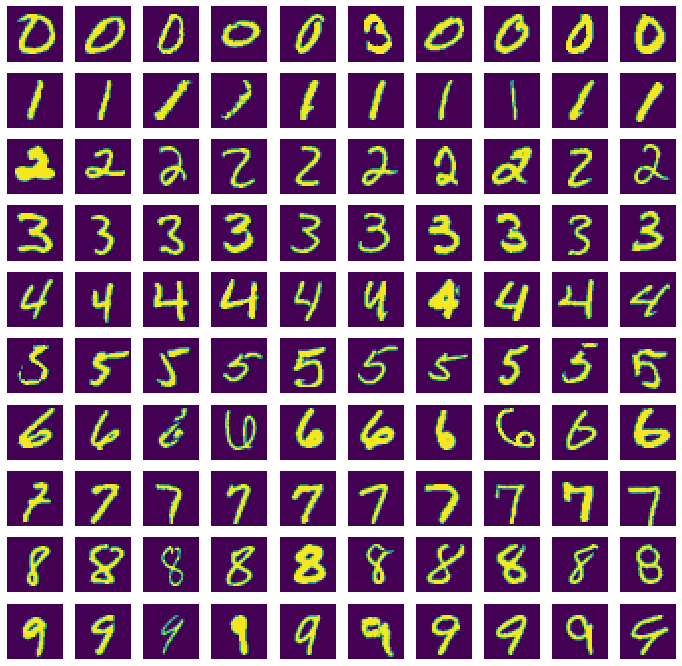

In [22]:
fig,axes = plt.subplots(nrows = 10, ncols = 10, figsize=(12,12))

for n in range(10):
    counter = 0
    for idx, out in enumerate(prob_list):
        if out.max(1)[1] == n:
            axes[n, counter].imshow(torch.squeeze(test_1000_list[idx][0]))
            axes[n, counter].axis('off')
            counter += 1
        if counter == 10:
            break
fig.show()

Since the accuracy is around 98.5%, we can see above that the model has classified almost all the images correctly, except for one or two misclassified ones. 

C:\Users\jayma\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


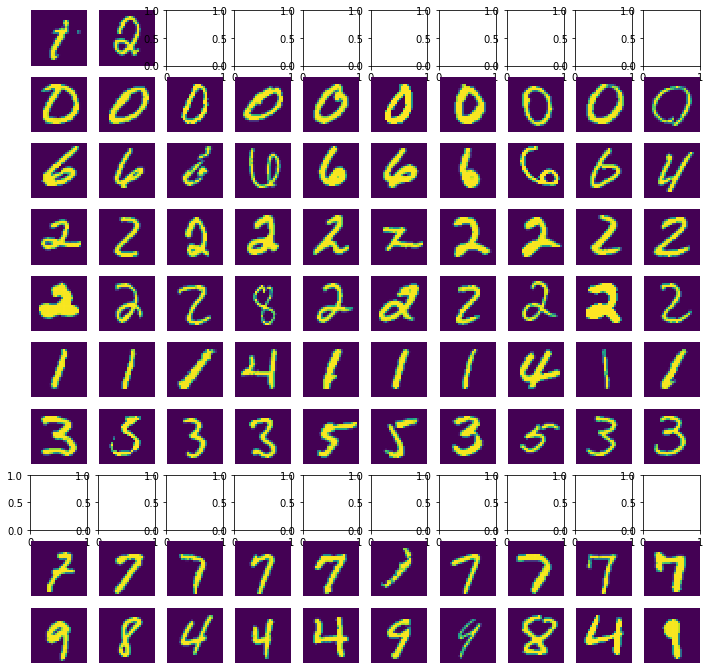

In [23]:
indices_fc5 = []
for i in range(10):
    x = random.randint(0, 1023)
    if x not in indices_fc5:
        indices_fc5.append(x)
        
##########################
## Below code is written with the help of code snippet taken from:
## https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.fc5.register_forward_hook(get_activation('fc5'))

##########################

fig2,axes = plt.subplots(nrows = 10, ncols = 10, figsize=(12,12))

with torch.no_grad():
    for n in range(10):
        counter = 0
        for img, labels in test_1000:
            img = img.to(device)
            output = model(img)
            second_last_layer = torch.tensor([activation['fc5'][0][idx] for idx in indices_fc5])
            if second_last_layer.max(0)[1].item() == n:
                img = img.to('cpu')
                axes[n, counter].imshow(torch.squeeze(img[0]))
                axes[n, counter].axis('off')
                counter += 1
            if counter == 10:
                break
fig.show()

We can see that we have a whole row missing and some of the images missing in the first row. For the second last layer, each example has 1024 dimensions (instead of 10). We randomly select 10 from 1024 for each example. It so happens that out of 1024 neurons many of them are not popular enough and thus are not activated. Neurons in the intermediate layers fire up only if they detect a certain feature or a pattern suitable for a particular class. In our case, some of the randomly selected neuron are not popular enough for that class and hence are not activated. 

An ideal condition in my opinion for second-to-last layer is that the images with similar features or patterns are grouped together. A glimpse of this is seen in the above image as 0's, 2's, 6's and 7's are grouped together. On the other hand 5's and 3's are grouped together and same way 9's and 4's are grouped together. This is bacause these pairs have similar patterns such as curves or straigh lines.

In [38]:
def class_mean(data, labels):
    coords = []
    for i in range(0, 10):
        temp = []
        for s in range(len(labels)):
            if(i == labels[s].item()):
                temp.append(data[s])
        labs = np.mean(temp, axis=0)
        coords.append(labs)
    return coords

torch.Size([1000, 784])
(1000, 2)


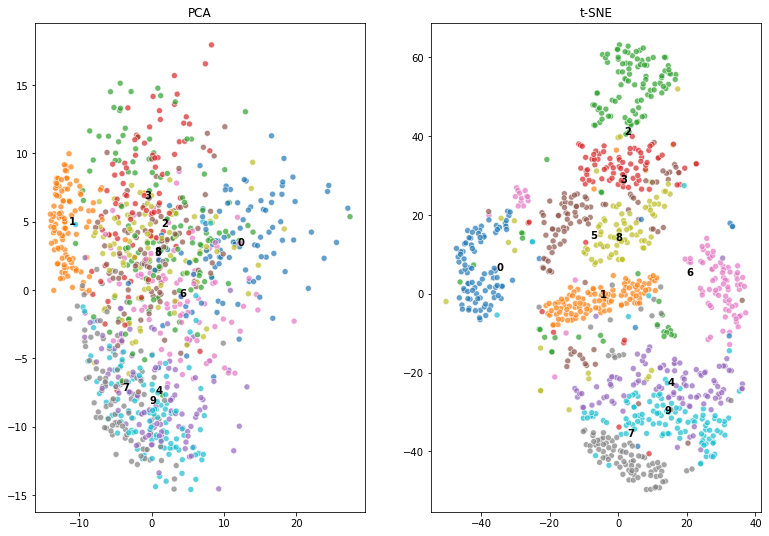

In [39]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


test_1000_list_flatten = []
test_1000_labels = []
for img, label in test_1000:
    img = img.view(img.shape[0], -1)
    test_1000_list_flatten.append(img)
    test_1000_labels.append(label)
    
test_1000_list_flatten = torch.cat(test_1000_list_flatten, 0)
test_1000_labels = torch.cat(test_1000_labels, 0)
print(test_1000_list_flatten.shape)

##### PCA #####
pca_ = PCA(n_components=2)
principleComponent = pca_.fit_transform(test_1000_list_flatten)

coords_pca = class_mean(principleComponent, test_1000_labels)

fig, axes = plt.subplots(ncols=2, figsize=(13,9))

sns.scatterplot(x=principleComponent[:,0], y=principleComponent[:,1], hue=test_1000_labels, 
                palette=sns.color_palette("tab10", n_colors=10),
                alpha=0.7, ax=axes[0], legend=False)
axes[0].set_title("PCA")
for i in range(10):
    axes[0].text(coords_pca[i][0], coords_pca[i][1], str(i), fontsize=10, weight='bold')

##### t-SNE #####
SNE_ = TSNE(n_components=2)
StochasticNeighbouring = SNE_.fit_transform(test_1000_list_flatten)
print(StochasticNeighbouring.shape)

coords_tsne = class_mean(StochasticNeighbouring, test_1000_labels)

sns.scatterplot(x=StochasticNeighbouring[:,0], y=StochasticNeighbouring[:,1],
                palette=sns.color_palette("tab10", n_colors=10), hue=test_1000_labels, 
                alpha=0.7, ax=axes[1], legend=False)
axes[1].set_title("t-SNE")
for i in range(10):
    axes[1].text(coords_tsne[i][0], coords_tsne[i][1], str(i), fontsize=10, weight='bold')

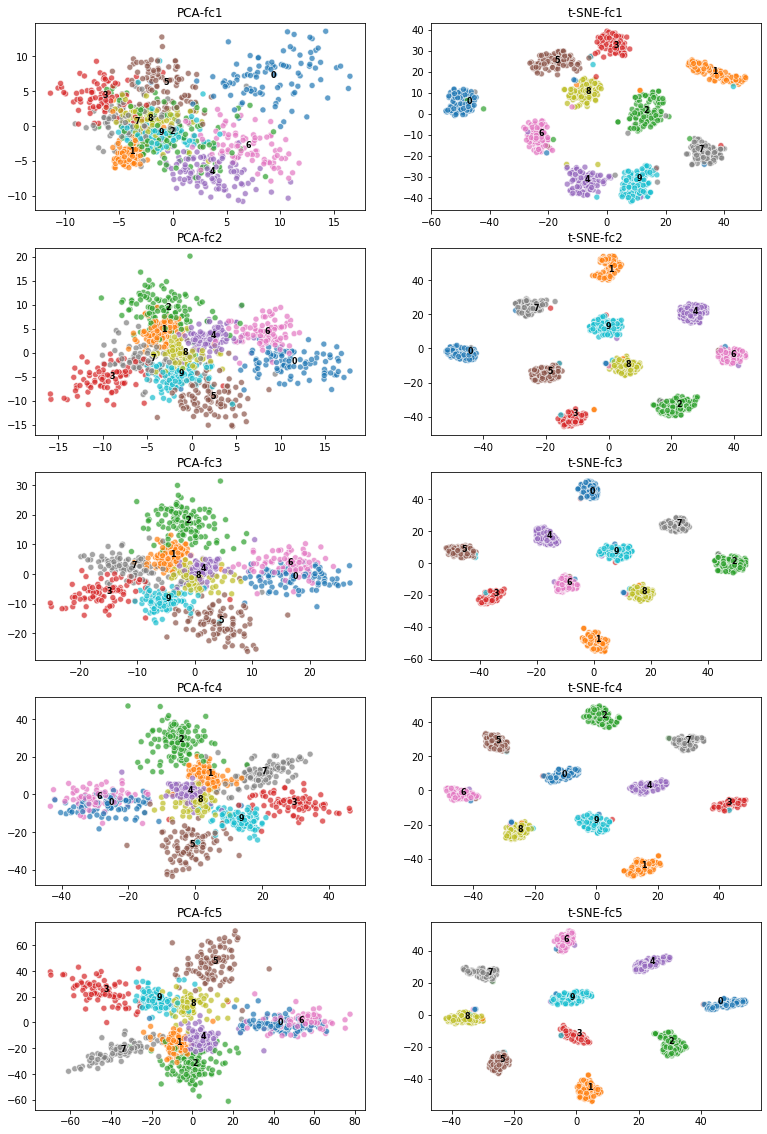

In [40]:
# register other models
model.fc1.register_forward_hook(get_activation('fc1'))
model.fc2.register_forward_hook(get_activation('fc2'))
model.fc3.register_forward_hook(get_activation('fc3'))
model.fc4.register_forward_hook(get_activation('fc4'))


layer_dict = {
    'fc1':[],
    'fc2':[],
    'fc3':[],
    'fc4':[],
    'fc5':[],
}

hidden_layers = ['fc1', 'fc2', 'fc3', 'fc4', 'fc5']

with torch.no_grad():
    for img, label in test_1000:
        img = img.to(device)
        output = model(img)
        for layer in hidden_layers:
            layer_dict[layer].append(activation[layer][0])

fig, axes = plt.subplots(nrows = 5, ncols=2, figsize=(13,20))
            
for i, layer in enumerate(hidden_layers):
    pca_ = PCA(n_components=2, random_state=0)
    principleComponent = pca_.fit_transform(torch.stack(layer_dict[layer]).to('cpu'))
    
    coords_pca = class_mean(principleComponent, test_1000_labels)
    
    axes[i][0].set_title("PCA-"+layer)
    for idx in range(10):
        axes[i, 0].text(coords_pca[idx][0], coords_pca[idx][1], str(idx), fontsize=8, weight='bold')

    sns.scatterplot(x=principleComponent[:,0], y=principleComponent[:,1], hue=test_1000_labels, 
                    palette=sns.color_palette("tab10", n_colors=10),
                    alpha=0.7, ax=axes[i][0], legend=False)
    
    SNE_ = TSNE(n_components=2, random_state=0)
    StochasticNeighbouring = SNE_.fit_transform(torch.stack(layer_dict[layer]).to('cpu'))
    
    coords_tsne = class_mean(StochasticNeighbouring, test_1000_labels)

    sns.scatterplot(x=StochasticNeighbouring[:,0], y=StochasticNeighbouring[:,1],
                    palette=sns.color_palette("tab10", n_colors=10), hue=test_1000_labels, 
                    alpha=0.7, ax=axes[i][1], legend=False)
    axes[i][1].set_title("t-SNE-"+layer)
    for idx in range(10):
        axes[i, 1].text(coords_tsne[idx][0], coords_tsne[idx][1], str(idx), fontsize=8, weight='bold')

Now we have plotted all the dimentionally reduced data for both tSNE and PCA for each layer. We can see that with each deeper layer the capability of the network to distinguish between the classes improves. This means the classification power of the network is improving as the layer is getting deeper. This can be attributed to the ability of the deeper layers to learn important patterns and features.

Also, tSNE performs better that PCA in dimentionality reduction. tSNE can distincly tell apart differnt classes. This is because tSNE tries to preserves the local structure(classes) of data by minimizing the KL divergence between two distributions with respect to the locations of the points in the map.

## Problem 2: Speech Denoising using Deep Learning

In [5]:
import librosa

s, sr=librosa.load('data/train_clean_male.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('data/train_dirty_male.wav', sr=None)
X=librosa.stft(sn, n_fft=1024, hop_length=512)

S_abs = torch.tensor(np.abs(S))
X_abs = torch.tensor(np.abs(X))
print("S_abs: ", S_abs.shape)
print("X_abs: ", X_abs.shape)

S_abs = S_abs.t()
X_abs = X_abs.t()
print("S_abs (transpose): ", S_abs.shape)
print("X_abs (transpose): ", X_abs.shape)

S_abs:  torch.Size([513, 2459])
X_abs:  torch.Size([513, 2459])
S_abs (transpose):  torch.Size([2459, 513])
X_abs (transpose):  torch.Size([2459, 513])


In [6]:
# Create a dataset and dataloader
import torch.utils.data as utils

dataset = utils.TensorDataset(X_abs, S_abs)
train_loader = utils.DataLoader(dataset, batch_size=50, shuffle=True)

# a, b = next(iter(train_loader))
# print(a.shape, b.shape)

In [7]:
class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()
        self.input = nn.Linear(513, 1026)
        self.fc1 = nn.Linear(1026, 1026)
        self.fc2 = nn.Linear(1026, 1026)
        self.fc3 = nn.Linear(1026, 1026)
        self.out = nn.Linear(1026, 513)
    
    def forward(self, x):    
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.out(x))
        return x

def weights_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight.data)
        nn.init.zeros_(layer.bias.data)

In [8]:
model2 = Denoiser()
model2.apply(weights_init)
print(model2)

err_func = nn.SmoothL1Loss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

Denoiser(
  (input): Linear(in_features=513, out_features=1026, bias=True)
  (fc1): Linear(in_features=1026, out_features=1026, bias=True)
  (fc2): Linear(in_features=1026, out_features=1026, bias=True)
  (fc3): Linear(in_features=1026, out_features=1026, bias=True)
  (out): Linear(in_features=1026, out_features=513, bias=True)
)


In [9]:
# Training the network
epochs = 30
 
for e in range(1, epochs+1):
    train_loss_epoch = 0
    for row, target in train_loader:
        # set the gradients to zero as PyTorch automatically accumulates gradients
        optimizer.zero_grad()
        
        # get the output from the model
        outs = model2(row)
        
        # calculate loss
        loss = err_func(outs, target)
        
        # Calculate gradients
        loss.backward()
        
        # Propagate gradients back
        optimizer.step()
        
        train_loss_epoch += loss.item()
    else:
        print(f"Overall Training loss for epoch {e}: {round(train_loss_epoch/len(train_loader),4)}")

Overall Training loss for epoch 1: 0.0179
Overall Training loss for epoch 2: 0.0121
Overall Training loss for epoch 3: 0.0079
Overall Training loss for epoch 4: 0.0062
Overall Training loss for epoch 5: 0.0052
Overall Training loss for epoch 6: 0.0046
Overall Training loss for epoch 7: 0.0041
Overall Training loss for epoch 8: 0.0037
Overall Training loss for epoch 9: 0.0034
Overall Training loss for epoch 10: 0.0032
Overall Training loss for epoch 11: 0.0031
Overall Training loss for epoch 12: 0.0029
Overall Training loss for epoch 13: 0.0027
Overall Training loss for epoch 14: 0.0026
Overall Training loss for epoch 15: 0.0024
Overall Training loss for epoch 16: 0.0023
Overall Training loss for epoch 17: 0.0022
Overall Training loss for epoch 18: 0.0021
Overall Training loss for epoch 19: 0.0021
Overall Training loss for epoch 20: 0.002
Overall Training loss for epoch 21: 0.002
Overall Training loss for epoch 22: 0.0019
Overall Training loss for epoch 23: 0.0018
Overall Training loss 

I tried out various architecture with different hyper-parameters, However, this model worked best for me and for this model I got the least final error (0.0016).

In [10]:
t1, tr1=librosa.load('data/test_x_01.wav', sr=None)
test_01=librosa.stft(t1, n_fft=1024, hop_length=512)
t2, tr2=librosa.load('data/test_x_02.wav', sr=None)
test_02=librosa.stft(t2, n_fft=1024, hop_length=512)

test_audio_01 = torch.tensor(np.abs(test_01))
test_audio_02 = torch.tensor(np.abs(test_02))
print("test_audio_01: ", test_audio_01.shape)
print("test_audio_02: ", test_audio_02.shape)

test_audio_01 = test_audio_01.t()
test_audio_02 = test_audio_02.t()
print("test_audio_01 (transpose): ", test_audio_01.shape)
print("test_audio_02 (transpose): ", test_audio_02.shape)

test_audio_01:  torch.Size([513, 142])
test_audio_02:  torch.Size([513, 380])
test_audio_01 (transpose):  torch.Size([142, 513])
test_audio_02 (transpose):  torch.Size([380, 513])


In [11]:
test_01_dataset = utils.TensorDataset(test_audio_01, test_audio_01)
test_01_loader = utils.DataLoader(test_01_dataset, batch_size=50, shuffle=False)

test_02_dataset = utils.TensorDataset(test_audio_02, test_audio_02)
test_02_loader = utils.DataLoader(test_02_dataset, batch_size=50, shuffle=False)

test_01_list = []
with torch.no_grad():
    for row, row_copy in test_01_loader:
        outs = model2(row)
        test_01_list.append(outs)
test_01_output = torch.cat(test_01_list, dim=0)

test_02_list = []
with torch.no_grad():
    for row, row_copy, in test_02_loader:
        outs = model2(row)
        test_02_list.append(outs)
test_02_output = torch.cat(test_02_list, dim=0)

def signal_cleaner(x_org, output):
    temp = x_org/np.abs(x_org)
    return np.multiply(temp, output.numpy())

clean_test_01 = signal_cleaner(test_01, test_01_output.t())
print("Shape of clean_test_01: ", clean_test_01.shape)
test_01_istft = librosa.core.istft(clean_test_01, hop_length=512)

clean_test_02 = signal_cleaner(test_02, test_02_output.t())
print("Shape of clean_test_02: ", clean_test_02.shape)
test_02_istft = librosa.core.istft(clean_test_02, hop_length=512)

Shape of clean_test_01:  (513, 142)
Shape of clean_test_02:  (513, 380)


In [12]:
import soundfile

soundfile.write("result_01.wav", test_01_istft, tr1)
soundfile.write("result_02.wav", test_02_istft, tr2)

In [13]:
# result for test_x_01.wav
import IPython.display as ipd
ipd.Audio('result_01.wav')

In [14]:
# result for test_x_02.wav
import IPython.display as ipd
ipd.Audio('result_02.wav')